## Question 7 - YOLOv5

In [1]:
import os
import cv2
import numpy as np
from PIL import Image

from pathlib import Path
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
# Windows Fix
# import pathlib
# pathlib.PosixPath = pathlib.WindowsPath

In [3]:
MODEL_NAME = 'data/yolov5.pt'

In [4]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'

## Convert data format

In [6]:
def convert_xml_to_yolo(root_dir):
    # Directories for the YOLO formatted annotations
    os.makedirs(os.path.join(root_dir, 'labels'), exist_ok=True)
    images_dir = os.path.join(root_dir, 'images')
    os.makedirs(images_dir, exist_ok=True)

    # Class mapping to index
    class_mapping = {'with_mask': 0, 'mask_weared_incorrect': 1, 'without_mask': 2}

    # Process each XML file
    for filename in os.listdir(root_dir):
        if not filename.endswith('.xml'):
            continue

        # Parse the XML File
        tree = ET.parse(os.path.join(root_dir, filename))
        root = tree.getroot()
        image_name = filename.replace('.xml', '')
        image_path = None

        # Find corresponding image file and convert to RGB
        for ext in ['.jpg', '.png']:
            if os.path.exists(os.path.join(root_dir, image_name + ext)):
                image_path = os.path.join(root_dir, image_name + ext)
                break

        if image_path:
            # Move image to 'images' folder and convert to RGB
            image = Image.open(image_path).convert("RGB")
            rgb_image_path = os.path.join(images_dir, image_name + '.png')  # Saving as PNG
            image.save(rgb_image_path)
            w, h = image.size

            # Create a corresponding YOLO format file
            with open(os.path.join(root_dir, 'labels', filename.replace('.xml', '.txt')), 'w') as f:
                for obj in root.findall('object'):
                    class_name = obj.find('name').text
                    if class_name not in class_mapping:
                        continue  # Skip unknown classes

                    # Convert XML box to YOLO format
                    bbox = obj.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)
                    x_center = ((xmin + xmax) / 2) / w
                    y_center = ((ymin + ymax) / 2) / h
                    width = (xmax - xmin) / w
                    height = (ymax - ymin) / h

                    # Write to file
                    f.write(f"{class_mapping[class_name]} {x_center} {y_center} {width} {height}\n")

In [7]:
# Convert both train and validation datasets
# convert_xml_to_yolo('data/MaskedFace/train')
# convert_xml_to_yolo('data/MaskedFace/val')

## Get the ground truth

In [8]:
def extract_true_labels_counts(label_files_dir, num_classes):
    # List all label files
    label_files = list(Path(label_files_dir).rglob('*.txt'))
    label_files.sort()
    counts = np.zeros((len(label_files), num_classes), dtype=int)
    filenames = []
    bounding_boxes = []

    for i, file_path in enumerate(label_files):
        with open(file_path) as f:
            box = []
            for line in f:
                class_id = int(line.split()[0])
                x_min = float(line.split()[1])
                y_min = float(line.split()[2])
                x_max = float(line.split()[3])
                y_max = float(line.split()[4])
                counts[i, class_id] += 1
                box.append([x_min, y_min, x_max, y_max])
        filenames.append(file_path.name)
        bounding_boxes.append(box)

    return bounding_boxes, counts, filenames

In [9]:
# Example usage
label_files_dir = 'data/MaskedFace/val/labels'
num_classes = 3

gt_boxes, gt_counts, gt_filenames = extract_true_labels_counts(label_files_dir, num_classes)

In [10]:
print("Ground Truth counts shape:", gt_counts.shape)

Ground Truth counts shape: (85, 3)


## Load the model

In [11]:
import sys
sys.path.append("yolov5")
from models.experimental import attempt_load
from utils.general import non_max_suppression

In [12]:
class MaskedFaceDataset(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.img_files = list(Path(root).rglob('*.png'))
        self.img_files.sort()
        self.transform = transform

    def __getitem__(self, idx):
        img_path = str(self.img_files[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
            filename=os.path.basename(img_path)
        return img, filename  # Return both the image and its path for visualization

    def __len__(self):
        return len(self.img_files)

In [13]:
val_dataset = MaskedFaceDataset(root='data/MaskedFace/val/images', transform=transform)

In [14]:
model = attempt_load(MODEL_NAME, device=device)
model.eval()

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv3): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): Sequential(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

## Test an image

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
index = 20
img, img_file = val_dataset[index]

Ground truth

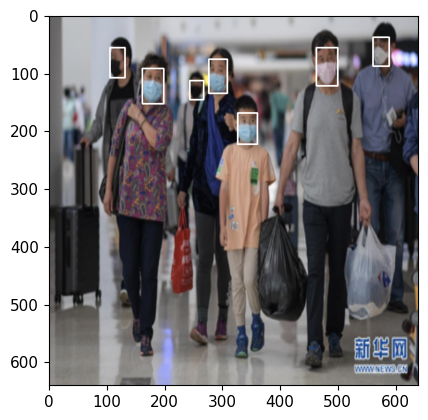

In [17]:
cv_img = (img.permute(1, 2, 0).numpy() * 255.0).astype(np.uint8).copy()
height, width, _ = cv_img.shape

for box in gt_boxes[index]:
    xc, yc, w, h = box
    x_min = int((xc - w / 2) * width)
    x_max = int((xc + w / 2) * width)
    y_min = int((yc - h / 2) * height)
    y_max = int((yc + h / 2) * height)
    cv2.rectangle( cv_img, 
                  (x_min, y_min), 
                  (x_max, y_max), (255, 255, 255), 2)

plt.imshow(cv_img)
plt.show()

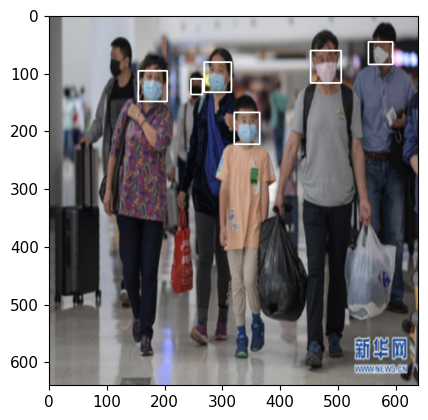

In [18]:
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=False)

cv_img = (img.permute(1, 2, 0).numpy() * 255.0).astype(np.uint8).copy()

for det in pred[0]:
#     print(det[0:2], det[2:4], det[4], det[5])
    cv2.rectangle( cv_img, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), (255, 255, 255), 2)

plt.imshow(cv_img)
plt.show()

## Test on the validation set

In [19]:
from tqdm import tqdm

def count_masks(model, dataset):

    predicted_counts = np.zeros((len(dataset), 3), dtype=int)
    filenames = []

    for idx, (img, filename) in enumerate(tqdm(dataset)):
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img)
            pred = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=False)

        if len(pred) > 0 and pred[0] is not None:
            for det in pred[0]:
                if det is None or len(det) == 0:
                    continue
                if det.dim() == 1:
                    det = det.unsqueeze(0)
                cls_ids = det[:, -1].cpu().numpy()
                for cls_id in cls_ids:
                    predicted_counts[idx, int(cls_id)] += 1

    return predicted_counts

In [20]:
predicted_counts = count_masks(model, val_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 75.81it/s]


## MAPE

In [21]:
def compute_mape(prediction, truth):
    mape = np.mean( np.abs(truth - prediction) / np.maximum(truth, np.ones_like(truth)) ) * 100
    return mape

In [22]:
MAPE = compute_mape(predicted_counts, gt_counts)

In [23]:
print(MAPE)

28.946963062185922


## Final Score

In [24]:
if MAPE <= 10:
    print("Score: ", 25*1.0)
elif MAPE <= 15:
    print("Score: ", 25*0.875)
elif MAPE <= 20:
    print("Score: ", 25*0.75)
elif MAPE <= 25:
    print("Score: ", 25*0.625)
elif MAPE <= 30:
    print("Score: ", 25*0.5)
else:
    print("Score: ", 0)  

Score:  12.5
